In [ ]:
!pip install 'aif360[LFR]' fairlearn gpflow

In [5]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas

In [ ]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [ ]:
# !cd /Users/jacob/opt/anaconda3/lib/python3.8/site-packages/aif360/data/raw/compas
# !wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import time
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels



import copy


from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.sklearn.datasets import standardize_dataset
from aif360.sklearn.preprocessing import Reweighing

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.models import SVGP
from gpflow import base

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)
tf.random.set_seed(123)

In [2]:
def load_adult():

    adult_dataset = load_preproc_data_adult(['sex'])

    #train, test = dataset_orig.split([0.7], shuffle=True, seed=3)
    #print("training data size", train.features.shape)
    #print("dataset feature names", train.feature_names)

    #data_preprocessing = Pipeline([("standardiser", StandardScaler()),
                                #("minmaxscaler", MinMaxScaler()),
                                    # ]
                                    # )


    adult_income_data, adult_dict = adult_dataset.convert_to_dataframe()

    X, y = standardize_dataset(df=adult_income_data, prot_attr='sex', target='Income Binary')

    return train_test_split(
        X,
        y,
        test_size=0.30,
        random_state=42
        )

def load_compas():

    compas_dataset = load_preproc_data_compas(['sex'])

    #train, test = dataset_orig.split([0.7], shuffle=True, seed=3)
    #print("training data size", train.features.shape)
    #print("dataset feature names", train.feature_names)

    #data_preprocessing = Pipeline([("standardiser", StandardScaler()),
                                #("minmaxscaler", MinMaxScaler()),
                                    # ]
                                    # )


    compas_income_data, compas_dict = compas_dataset.convert_to_dataframe()

    print(compas_dataset.feature_names)

    X, y = standardize_dataset(df=compas_income_data, prot_attr=['race'], target='two_year_recid')

    return train_test_split(
        X,
        y,
        test_size=0.30,
        random_state=42
        )


In [11]:
# x_train = train.features
# x_test = test.features
# # x_train = data_preprocessing.fit_transform(train.features)
# # x_test = data_preprocessing.fit_transform(test.features)
# y_train = train.labels.ravel()
# y_test = test.labels.ravel()

#training_data = (x_train, y_train)


# N = len(x_train)
# M = 400
print("Number of training datapoints:", len(X_train))
print("Number of features", len(X_train.columns))

Number of training datapoints: 3694
Number of features 10


## Model Training

### Setting up the model

In [12]:
class FairSVGP(SVGP):

    def __init__(
        self,
        kernel,
        likelihood,
        inducing_variable,
        *,
        mean_function=None,
        num_latent_gps: int = 1,
        q_diag: bool = False,
        q_mu=None,
        q_sqrt=None,
        whiten: bool = True,
        num_data=None,
        sample_weights=None,
        ):
        super().__init__(kernel, likelihood, inducing_variable, mean_function=mean_function, num_latent_gps=num_latent_gps, q_diag=q_diag, q_mu=q_mu, q_sqrt=q_sqrt, whiten=whiten, num_data=num_data)
        self.sample_weights = sample_weights

    def elbo(self, data) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y, sample_weights = data
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X, full_cov=False, full_output_cov=False)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)
        return tf.reduce_sum(var_exp*sample_weights) * scale - kl





In [27]:
class SVGP_binary_classifier(ClassifierMixin, BaseEstimator):
    """ A binary classifier that uses SVGP (Hensman, 2013).

    Parameters
    ----------
    M : int, default=100
        The number of inducing points to be used (comuptation scales as O(M^3)).

    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, M=100):
        self.M = M

        self.elbo_training_log = []
        self.fairness_log = []
        

    def run_adam(self, model, iterations, training_data, minibatch_size):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action

        train_dataset = tf.data.Dataset.from_tensor_slices(training_data).repeat().shuffle(self.N)

        print(train_dataset)

        logf = []

        
        
        # minibatch_perms = iter(range(iterations))
        # # print(type(X))
        # # print(len(X))
        # # print(len(sample_weights))
        # # print(X[1])

        #print(training_data)

        

        def pick_minibatch(minibatch_size, sample_weights):
            # np.random.seed(next(minibatch_perms))
            p = np.array(sample_weights)/sum(sample_weights)
            minibatch_index = np.random.choice(
                range(self.N), size=minibatch_size, replace=False, p=p)
            
            X_mini = []
            y_mini = []

            for index in minibatch_index:
                X_mini.append(X[index])
                y_mini.append(y[index])

            X_mini = np.array(X_mini)
            y_mini = np.array(y_mini)

            return tf.data.Dataset.from_tensor_slices((X_mini, y_mini)).repeat().shuffle(minibatch_size) 

        #print(pick_minibatch(minibatch_size, sample_weights))



        #train_iter = iter(pick_minibatch(minibatch_size, sample_weights).batch(minibatch_size))

        train_iter = iter(train_dataset.batch(minibatch_size))

        training_loss = model.training_loss_closure(train_iter, compile=True)
        optimizer = tf.optimizers.Adam()

        @tf.function
        def optimization_step():
            optimizer.minimize(training_loss, model.trainable_variables)

        for step in range(iterations):
            optimization_step()
            if step % 10 == 0:
                elbo = -training_loss().numpy()
                logf.append(elbo/minibatch_size)
        return logf    


    def fit(self,
            X,
            y,
            minibatch_size=130,
            total_iterations=10000,
            show_training_curve=False,
            show_training_summary=False,
            robustmax_epsilon=0.001,
            sample_weights=None,
            q_mu_prior=None,
        ):
        """Fits the SVGP classifier to data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        minibatch_size : int
        total_iterations : int
        q_mu_prior: None for a balanced prior, "ones" for a prior
                    that places certainty on the target label = 1 for all
                    samples, "zeros" for target label = 0 for all samples.

        Returns
        -------
        self : object
            Returns self.
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.N = len(y)
        self.C = len(self.classes_)

        if sample_weights is None:
            sample_weights = np.ones(shape=(self.N,))
        else:
            assert len(sample_weights) == self.N
        self.sample_weights = sample_weights

        kernel_multi = gpflow.kernels.Matern52() + gpflow.kernels.White(variance=0.01)

        # Robustmax Multiclass Likelihood
        
        invlink = gpflow.likelihoods.RobustMax(
            self.C,
            epsilon=robustmax_epsilon
            )  # Robustmax inverse link function

        likelihood_multi = gpflow.likelihoods.MultiClass(
            self.C,
            invlink=invlink
            )  # Multiclass likelihood

        Z = X[:self.M].copy()  # inducing inputs

        # Defining the prior for q_mu:
        if q_mu_prior is not None:
            if q_mu_prior == "ones":
                q_mu = np.zeros(shape=[self.M, 2])
                q_mu[:,1]=1
            elif q_mu_prior == "zeros":
                q_mu = np.zeros(shape=[self.M, 2])
                q_mu[:,0]=1
            else:
                q_mu = q_mu_prior
        else:
            q_mu = None

        
        # Instantiating the model
        self.m = FairSVGP(
            kernel=kernel_multi,
            likelihood=likelihood_multi,
            inducing_variable=Z,
            num_latent_gps=self.C,
            whiten=True,
            q_diag=True,
            q_mu=q_mu,
            sample_weights=self.sample_weights
        )

        # Setting trainable parameters
        set_trainable(self.m.kernel.kernels[0].variance, False)
        set_trainable(self.m.inducing_variable, False)


        self.mb_size = minibatch_size
        training_data = (X, y, sample_weights)
        maxiter = ci_niter(total_iterations)
        self.elbo_training_log = self.run_adam(
            self.m,
            maxiter,
            training_data,
            self.mb_size,
            self.sample_weights,
            )
        
        if show_training_curve==True:
            plt.plot(np.linspace(0, total_iterations, len(self.elbo_training_log)), self.elbo_training_log)
            plt.xlabel("Iteration")
            plt.ylabel("ELBO per data point")
            plt.title("Training curve")
            plt.show()

        if show_training_summary==True:
            print_summary(self.m, fmt="notebook")

        # Return the classifier
        return self


    def predict(self, X_test):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X_test = check_array(X_test)

        mu, _ = self.m.predict_y(X_test)
        predictions = []
        for probs in mu:
            prediction = np.argmax(probs)
            predictions.append(prediction)
        return predictions


In [4]:
X_train, X_test, y_train, y_test = load_compas()

print(X_train.columns)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



IOError: [Errno 2] No such file or directory: '/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/aif360/datasets/../data/raw/compas/compas-scores-two-years.csv'
To use this class, please download the following file:

	https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

and place it, as-is, in the folder:

	/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/aif360/data/raw/compas

Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/aif360/datasets/compas_dataset.py", line 68, in __init__
    df = pd.read_csv(filepath, index_col='id', na_values=na_values)
  File "/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 610, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers.py", line 462, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/Users/jacob/opt/ana

TypeError: object of type 'NoneType' has no len()

<ShuffleDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>


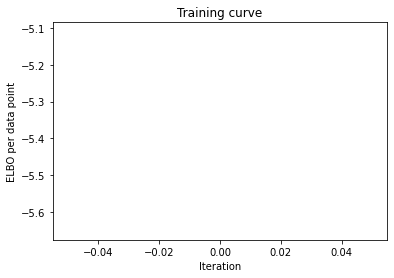

name,class,transform,prior,trainable,shape,dtype,value
FairSVGP.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
FairSVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.001159958205374
FairSVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.009992950274385995
FairSVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
FairSVGP.inducing_variable.Z,Parameter,Identity,,False,"(400, 10)",float64,"[[0., 0., 0...."
FairSVGP.q_mu,Parameter,Identity,,True,"(400, 2)",float64,"[[9.99620070e-01, -1.79372442e-03..."
FairSVGP.q_sqrt,Parameter,Softplus,,True,"(400, 2)",float64,"[[0.99883854, 0.99883854..."


SVGP_classifier(M=400)

In [28]:
rewe = Reweighing(["race"])
# We obtain a set of weights for the training set, to use in scikit-learn.
_, reweights = rewe.fit_transform(X_train, y_train)
reweights = np.array(reweights)

classify_me = SVGP_binary_classifier(400)
classify_me.fit(X_train, y_train, minibatch_size=100, total_iterations=2, show_training_curve=True, sample_weights=None, show_training_summary=True)



In [3]:
from fairlearn.metrics import true_positive_rate

def tpr_differ(y_test, predictions, pos_label=1):
    female_test = []
    male_test = []
    female_pred = []
    male_pred = []
    for i, index in enumerate(list(y_test.index)):
        if index[1]==0:
            female_test.append(y_test[index])
            female_pred.append(predictions[i])
        if index[1]==1:
            male_test.append(y_test[index])
            male_pred.append(predictions[i])
    tpr_male = true_positive_rate(male_test, male_pred, pos_label=pos_label)
    tpr_female = true_positive_rate(female_test, female_pred, pos_label=pos_label)
    return tpr_female-tpr_male

def positives_ratio(y_test, predictions):
    test_positives = list(y_test).count(1)
    pred_positives = predictions.count(1)
    return pred_positives/test_positives


### Training the models

In [29]:
y_pred = classify_me.predict(X_test)


print(tpr_differ(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(positives_ratio(y_test, y_pred))

print(reweights[:30])




0.0
0.5359848484848485
0.0
[1.11894392 0.89418163 0.86346393 0.89418163 0.86346393 1.11894392
 1.21364711 0.89418163 0.89418163 0.86346393 0.89418163 1.11894392
 0.86346393 1.21364711 0.89418163 1.11894392 0.86346393 1.11894392
 0.86346393 1.21364711 1.11894392 0.89418163 0.86346393 1.21364711
 1.11894392 0.89418163 0.89418163 1.11894392 1.11894392 0.86346393]


In [ ]:
# mb_sizes = list(np.linspace(10, 500, 50, dtype=int))
# print(mb_sizes)

epsilons = [0.001, 0.01, 0.1]#range(0.001, 510, 10)

scoring_metrics = {"accuracy": "accuracy", "equal_opportunity_difference": make_scorer(tpr_differ)}

score_log = []

with tf.device('/device:GPU:0'):
    for epsilon in epsilons:
        print(epsilon)
        svgpclass = SVGP_classifier(400)
        scores = cross_validate(svgpclass, X_train, y_train, scoring=scoring_metrics, cv=5, fit_params={"robustmax_epsilon": epsilon, "total_iterations":10000})
        print("RobustMax epsilon:", epsilon, "\n", "average accuracy:",np.mean(scores["test_accuracy"]), "     Average equal opportunity difference:",np.mean(scores["test_equal_opportunity_difference"]))
        score_log.append(scores)


10
Minibatch size: 10 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
20
Minibatch size: 20 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
30
Minibatch size: 30 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
40
Minibatch size: 40 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
50
Minibatch size: 50 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
60
Minibatch size: 60 
 average accuracy: 0.7660063827813008      Average equal opportunity difference: -0.08679514632405425
70
Minibatch size: 70 
 average accuracy: 0.7724712065344088      Average equal opportunity difference: -0.13902536215139238
80
Minibatch size: 80 
 average accuracy: 0.8007545355962129      Average equal opportunity difference: -0.4269792499407056
90
Minibatch size: 90 
 average accuracy: 0.8007252872779912      Average equal opport

KeyboardInterrupt: ignored

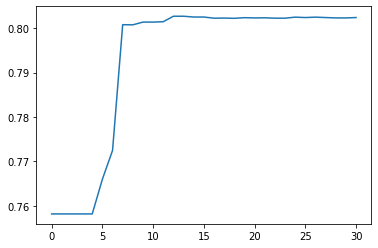

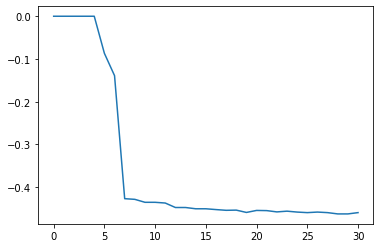

In [ ]:
accuracies = []
fairnesses = []

for score in score_log:
    fairness = np.mean(score["test_equal_opportunity_difference"])
    accuracy = np.mean(score["test_accuracy"])
    accuracies.append(accuracy)
    fairnesses.append(fairness)

plt.plot(accuracies)
plt.show()

plt.plot(fairnesses)
plt.show()

In [ ]:



# elbo_training_logs = []
# models = []


# with tf.device('/device:GPU:0'):
#     for mb_size in mb_sizes:
#         model = copy.deepcopy(m)
#         elbo_training_log = run_adam(model, maxiter, training_data, mb_size)
#         elbo_training_logs.append(np.array(elbo_training_log)/mb_size)
#         models.append(model)


# for log in elbo_training_logs:
#     plt.plot(range(0, total_iterations, 10), log)
#     plt.show()

In [ ]:





# def calculate_test_accuracy(model, x_test, y_test):
#     predictions = predict_targets(model, x_test)
#     total_correct = 0
#     for i in range(len(x_test)):
#         if predictions[i]==y_test[i]:
#             total_correct += 1

#     return total_correct/len(predictions)


# def logistic_regression_accuracy(training_data, x_test, y_test):
#     model = LogisticRegression()
#     model.fit(*training_data)
#     predictions = model.predict(x_test)
#     return accuracy_score(y_test, predictions)

# def mlp_accuracy(training_data, x_test, y_test):
#     model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
#     model.fit(*training_data)
#     predictions = model.predict(x_test)
#     return accuracy_score(y_test, predictions)


# fairness_scores = []
# test_accuracies = []

# for i in range(len(models)):
#     test_accuracy = calculate_test_accuracy(models[i], x_test, y_test)
#     print(f"SVGP accuracy (minibatch = {mb_sizes[i]}):", test_accuracy)
#     test_accuracies.append(test_accuracy)
#     predictions = predict_targets(models[i], x_test)
#     test_pred = test.copy()
#     test_pred.labels = np.array(predictions)
#     fairness_metric = ClassificationMetric(
#         test, 
#         test_pred,
#         unprivileged_groups=unprivileged_groups, 
#         privileged_groups=privileged_groups
#         )
#     fairness_scores.append(fairness_metric.equal_opportunity_difference())
# print("Logistic Regression accuracy:", logistic_regression_accuracy(training_data, x_test, y_test))
# print("MLP accuracy:", mlp_accuracy(training_data, x_test, y_test))

